## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
file = '/Users/cmart/Lab of Computational Physics/data/data_000637.txt'
N = 100000
data = pd.read_csv(file, nrows = N)
data.columns

Index(['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS'], dtype='object')

2\. Find out the number of BX in a ORBIT (the value 'x').

In [4]:
bx_tot = data["BX_COUNTER"].max() - data["BX_COUNTER"].min()
orb_tot = data["ORBIT_CNT"].max() - data["ORBIT_CNT"].min()
x = bx_tot/orb_tot
print('The number of BX in a ORBIT is:', np.round(x,2))

The number of BX in a ORBIT is: 3.58


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [5]:
# Find the first measurement (smallest time)
t0 = data[data["ORBIT_CNT"] == data["ORBIT_CNT"].min()]
t0 = t0[t0["BX_COUNTER"] == t0["BX_COUNTER"].min()]
t0 = t0[t0["TDC_MEAS"] == t0["TDC_MEAS"].min()]

# Find the last measurement (biggest time)
tf = data[data["ORBIT_CNT"] == data["ORBIT_CNT"].max()]
tf = tf[tf["BX_COUNTER"] == tf["BX_COUNTER"].max()]
tf = tf[tf["TDC_MEAS"] == tf["TDC_MEAS"].max()]

# Solve the total time
nanoseconds = lambda t: t[0]*x*25+t[1]*25+t[2]*25/30
time = nanoseconds(tf.values[0][-3:] - t0.values[0][-3:])
print('Data taking lasted:', np.round(time,2), 'nanoseconds')

Data taking lasted: 93838.33 nanoseconds


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [6]:
data["TOTAL_TIME"] = [nanoseconds(t[-3:]) for t in data.values]
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TOTAL_TIME
0,1,0,123,3869200167,2374,26,3.467294e+11
1,1,0,124,3869200167,2374,27,3.467294e+11
2,1,0,63,3869200167,2553,28,3.467294e+11
3,1,0,64,3869200167,2558,19,3.467294e+11
4,1,0,64,3869200167,2760,25,3.467295e+11
...,...,...,...,...,...,...,...
99995,1,0,64,3869201161,2378,29,3.467295e+11
99996,1,0,70,3869201161,2472,26,3.467295e+11
99997,1,0,58,3869201161,2558,0,3.467295e+11
99998,1,0,57,3869201161,2561,23,3.467295e+11


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [7]:
import numpy.random as npr
npr.seed(272)
data.loc[:,'HEAD'] = npr.randint(0, 2, size=(N,1))

data['HEAD'].value_counts()

1    50116
0    49884
Name: HEAD, dtype: int64

6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [8]:
data_head1 = data[data['HEAD']==1]

data_head1['HEAD'].value_counts()

1    50116
Name: HEAD, dtype: int64

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

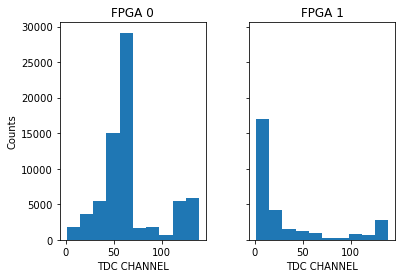

In [9]:
data_F0 = data[data['FPGA'] == 0].sort_values(by='TDC_CHANNEL')
data_F1 = data[data['FPGA'] == 1].sort_values(by='TDC_CHANNEL')

figure, (fpga0, fpga1) = plt.subplots(nrows = 1, ncols = 2, sharey='row')
fpga0.hist(data_F0['TDC_CHANNEL'])
fpga0.set_title('FPGA 0')
fpga0.set_xlabel('TDC CHANNEL')
fpga1.hist(data_F1['TDC_CHANNEL'])
fpga1.set_title('FPGA 1')
fpga1.set_xlabel('TDC CHANNEL')
fpga0.set_ylabel('Counts')
plt.subplots_adjust(wspace = 0.3)
plt.show()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [10]:
top3 = (data.groupby(['TDC_CHANNEL']).count().sort_values(by='HEAD', ascending=0)).index.values[0:3]
print("The noisy channels are:", top3)

The noisy channels are: [139  64  63]


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [11]:
data_channel139 = data[data['TDC_CHANNEL']==139]
print("The number of unique orbits of TDC_CHANNEL = 139 are:", len(data_channel139['ORBIT_CNT'].unique()))

The number of unique orbits of TDC_CHANNEL = 139 are: 994
